In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('/kaggle/input/rucode-2024-1/disease_train.csv')
df.head()

,X1,X2,X3,X4,X5,X6,X7,Y
0,2.0,2.0,29.4,84.0,2.0,75.0,5.78,0
1,1.0,2.0,33.5,101.0,2.0,64.0,8.74,0
2,1.0,2.0,29.2,101.0,2.0,80.0,9.72,0
3,1.0,2.0,28.7,121.0,2.0,146.0,3.83,0
4,1.0,1.0,25.6,87.0,2.0,82.0,13.90,0


In [3]:
X, y = df.drop(['Y'], axis=1), df['Y']

In [4]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)
class_weights

array([0.59559373, 3.11523438])

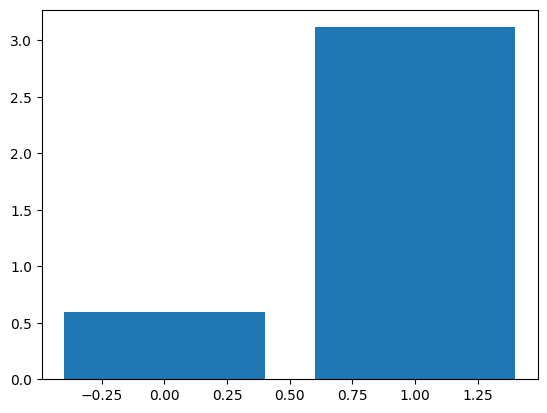

In [5]:
plt.bar(np.unique(y), class_weights)
plt.show()

In [6]:
df.isna().any().sum()

0

In [7]:
df.describe()

,X1,X2,X3,X4,X5,X6,X7,Y
count,1595.000000,1595.000000,1595.000000,1595.000000,1595.000000,1595.000000,1595.000000,1595.000000
mean,1.503448,1.820063,28.102320,99.715361,2.020690,115.754232,11.955455,0.160502
std,0.500145,0.408011,7.307291,17.035404,0.194526,47.079751,9.719597,0.367186
min,1.000000,1.000000,14.600000,63.000000,1.000000,40.000000,0.140000,0.000000
25%,1.000000,2.000000,23.000000,92.000000,2.000000,88.000000,5.810000,0.000000
50%,2.000000,2.000000,27.000000,97.000000,2.000000,106.000000,9.090000,0.000000
75%,2.000000,2.000000,31.500000,104.000000,2.000000,131.000000,14.570000,0.000000
max,2.000000,7.000000,70.100000,368.000000,3.000000,503.000000,81.790000,1.000000


In [8]:
for i in range(1, 8):
    curr = X[f'X{i}'].unique()
    if len(curr) <= 10:
        print(i, *curr)

1 2.0 1.0
2 2.0 1.0 7.0
5 2.0 3.0 1.0


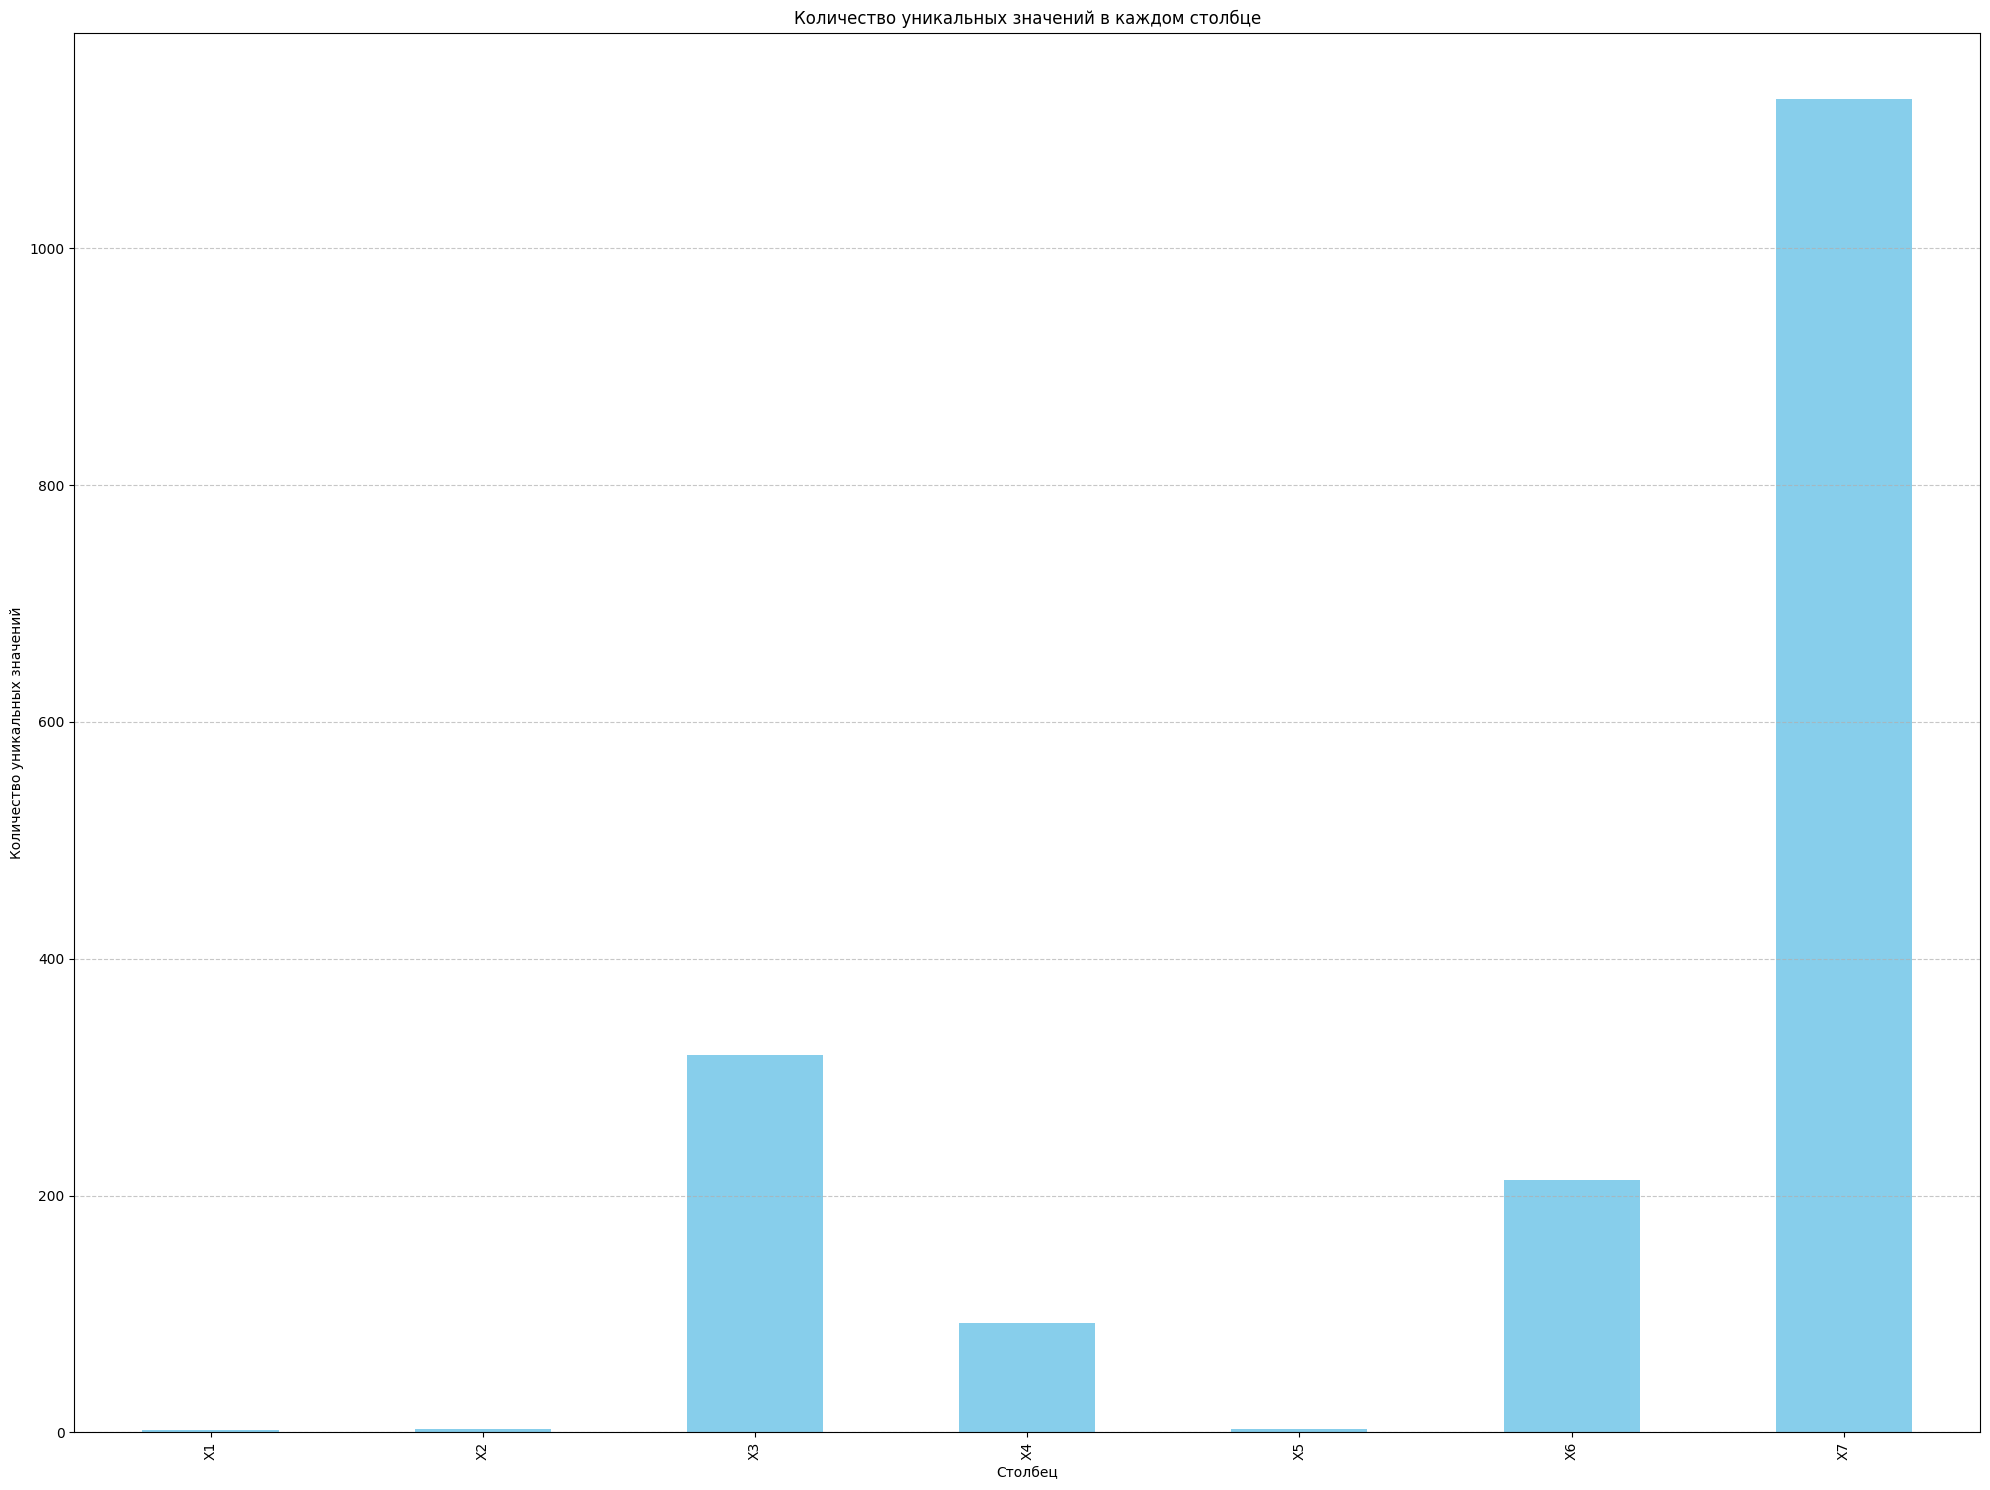

In [9]:
unique_counts = X.nunique()

plt.figure(figsize=(20, 15))
unique_counts.plot(kind='bar', color='skyblue')
plt.title('Количество уникальных значений в каждом столбце')
plt.xlabel('Столбец')
plt.ylabel('Количество уникальных значений')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
cat_features = ['X1', 'X2', 'X5']

In [11]:
for feat in cat_features:
    X[feat] = X[feat].astype('int16')

In [12]:
num_features = [x for x in X.columns if x not in cat_features]
num_features

['X3', 'X4', 'X6', 'X7']

In [13]:
corr_matrix = X[num_features].corr().abs()

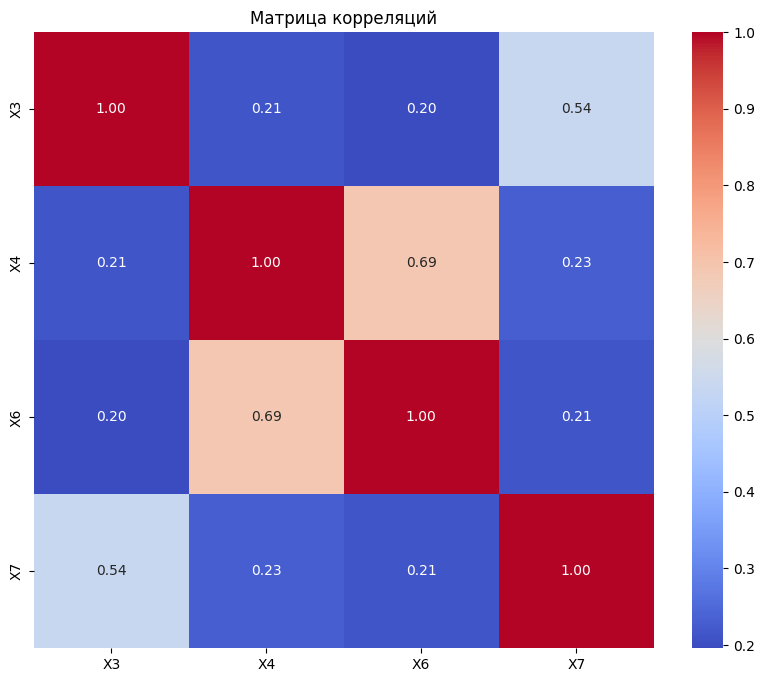

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляций')
plt.show()

In [15]:
X['X6_sin'] = np.sin(X['X6'])
#X['X4_cos'] = np.cos(X['X4'])
X['ratio_4'] = X['X4'] / X['X6']

In [16]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True)

poly_features = poly.fit_transform(X[num_features])
poly_feature_names_1 = [f'poly_{i}' for i in range(poly_features.shape[1])]

X_poly_1 = pd.DataFrame(poly_features, columns=poly_feature_names_1)
X = pd.concat([X, X_poly_1], axis=1)

In [17]:
corr_matrix = X[[x for x in X.columns if x not in cat_features]].corr().abs()

In [18]:
threshold = 0.9

high_corr_features = corr_matrix[corr_matrix > threshold]
high_corr_features = high_corr_features.unstack().dropna().to_dict()

printed_features = set()
for (feature1, feature2), corr in high_corr_features.items():
    if feature1 != feature2 and (feature1, feature2) not in printed_features and (feature2, feature1) not in printed_features:
        print(f"{feature1} и {feature2} имеют корреляцию {corr}")
        printed_features.add((feature1, feature2))

X3 и poly_1 имеют корреляцию 1.0
X4 и poly_2 имеют корреляцию 1.0
X6 и poly_3 имеют корреляцию 1.0
X7 и poly_4 имеют корреляцию 1.0
X7 и poly_7 имеют корреляцию 0.955082764613244
X7 и poly_9 имеют корреляцию 0.9576145896056616
poly_4 и poly_7 имеют корреляцию 0.955082764613244
poly_4 и poly_9 имеют корреляцию 0.9576145896056616
poly_7 и poly_9 имеют корреляцию 0.9373770398487629
poly_9 и poly_10 имеют корреляцию 0.9361401770934227


In [19]:
X = X.drop(['poly_0', 'poly_1', 'poly_2', 'poly_3', 'poly_4'], axis=1)

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42, stratify=y_temp)

In [21]:
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC, RandomOverSampler
from imblearn.combine import SMOTETomek

smote = SMOTE(random_state=42) 
smotenc = SMOTENC(random_state=42, categorical_features=cat_features) 
adasyn = ADASYN(random_state=42)
rus = RandomUnderSampler(random_state=42)
ros = RandomOverSampler(random_state=42)
tomek = TomekLinks()
smt = SMOTETomek(random_state=42)

X_smote, y_smote = smote.fit_resample(X_train, y_train) 
X_smotenc, y_smotenc = smotenc.fit_resample(X_train, y_train)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
X_train_tomek, y_train_rus_tomek = tomek.fit_resample(X_train, y_train)
X_train_smt, y_train_rus_smt = smt.fit_resample(X_train, y_train)

In [22]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, classification_report, f1_score

In [23]:
tholds = (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9)

In [24]:
results = {'SMOTE': [], 'ADASYN': [], 'SMOTENC': [], 'ROS': [], 'RUS': [], 'TOMEK': [], 'SMOTETOMEK': [], 'CLASS WEIGHTS': [], 'NOTHING': []}
models = {'SMOTE': [], 'ADASYN': [], 'SMOTENC': [], 'ROS': [], 'RUS': [], 'TOMEK': [], 'SMOTETOMEK': [], 'CLASS WEIGHTS': [], 'NOTHING': []}

for (train, test, type_) in (
    (X_smote, y_smote, 'SMOTE'), 
    (X_smotenc, y_smotenc, 'SMOTENC'), 
    (X_adasyn, y_adasyn, 'ADASYN'), 
    (X_train_ros, y_train_ros, 'ROS'), 
    (X_train_rus, y_train_rus, 'RUS'), 
    (X_train_tomek, y_train_rus_tomek, 'TOMEK'),
    (X_train_smt, y_train_rus_smt, 'SMOTETOMEK'),
    (X_train, y_train, 'NOTHING')
):
    
    model = CatBoostClassifier(eval_metric='F1',
                               custom_metric='F1',
                               cat_features=cat_features)
    
    model.fit(train, test, eval_set=(X_val, y_val), silent=True)
    
    pred_probas = model.predict_proba(X_test)[:, 1]
    
    f1s = []
    
    for thold in tholds:
        predictions = (pred_probas >= thold)
        f1s.append(f1_score(y_test, predictions, average='macro'))
    
    f1 = max(f1s)
    best_thold = (f1s.index(f1) + 1) / 10
    
    auc = roc_auc_score(y_test, pred_probas)
    
    results[type_] = [f1, auc, best_thold]
    models[type_] = model
    
    print(f'{type_} DONE, f1: {f1}, auc: {auc}, best_thold: {best_thold}')

SMOTE DONE, f1: 0.6000558829506198, auc: 0.7201792539870832, best_thold: 0.5
SMOTENC DONE, f1: 0.6242990654205607, auc: 0.702846975088968, best_thold: 0.4
ADASYN DONE, f1: 0.6038217353417155, auc: 0.6952023197574798, best_thold: 0.5
ROS DONE, f1: 0.6548594416916058, auc: 0.7147752734941347, best_thold: 0.4
RUS DONE, f1: 0.5588253393887925, auc: 0.6680835639910373, best_thold: 0.5
TOMEK DONE, f1: 0.6202839099692341, auc: 0.727164887307236, best_thold: 0.4
SMOTETOMEK DONE, f1: 0.6166739189995003, auc: 0.7079214445762488, best_thold: 0.6
NOTHING DONE, f1: 0.6103191971767118, auc: 0.7129959140635297, best_thold: 0.4


In [25]:
model = CatBoostClassifier(eval_metric='F1:use_weights=False',
                           custom_metric='F1:use_weights=False',
                           class_weights=class_weights,
                           cat_features=cat_features)

model.fit(X_train, y_train, eval_set=(X_val, y_val), silent=True)

pred_probas = model.predict_proba(X_test)[:, 1]

f1s = []
    
for thold in tholds:
    predictions = (pred_probas >= thold)
    f1s.append(f1_score(y_test, predictions, average='macro'))
    
f1 = max(f1s)
best_thold = (f1s.index(f1) + 1) / 10
    
auc = roc_auc_score(y_test, pred_probas)

results['CLASS WEIGHTS'] = [f1, auc, best_thold]
models['CLASS WEIGHTS'] = model

print(f'CLASS WEIGHTS DONE, f1: {f1}, auc: {auc}, best_thold: {best_thold}')

CLASS WEIGHTS DONE, f1: 0.6414299985728558, auc: 0.7102939238170555, best_thold: 0.6


In [26]:
models

{'SMOTE': <catboost.core.CatBoostClassifier at 0x7c493b45c6d0>,
 'ADASYN': <catboost.core.CatBoostClassifier at 0x7c493b44df60>,
 'SMOTENC': <catboost.core.CatBoostClassifier at 0x7c493b45c7c0>,
 'ROS': <catboost.core.CatBoostClassifier at 0x7c493b44dfc0>,
 'RUS': <catboost.core.CatBoostClassifier at 0x7c493b49d630>,
 'TOMEK': <catboost.core.CatBoostClassifier at 0x7c493b49fe80>,
 'SMOTETOMEK': <catboost.core.CatBoostClassifier at 0x7c493b49eaa0>,
 'CLASS WEIGHTS': <catboost.core.CatBoostClassifier at 0x7c49202dfbb0>,
 'NOTHING': <catboost.core.CatBoostClassifier at 0x7c493b49feb0>}

In [27]:
res = pd.DataFrame(results, index=['f1', 'auc', 'best_thold'])
res = res.T
res = res.rename_axis('Method')
res

,f1,auc,best_thold
Method,,,
SMOTE,0.600056,0.720179,0.5
ADASYN,0.603822,0.695202,0.5
SMOTENC,0.624299,0.702847,0.4
ROS,0.654859,0.714775,0.4
RUS,0.558825,0.668084,0.5
TOMEK,0.620284,0.727165,0.4
SMOTETOMEK,0.616674,0.707921,0.6
CLASS WEIGHTS,0.641430,0.710294,0.6
NOTHING,0.610319,0.712996,0.4


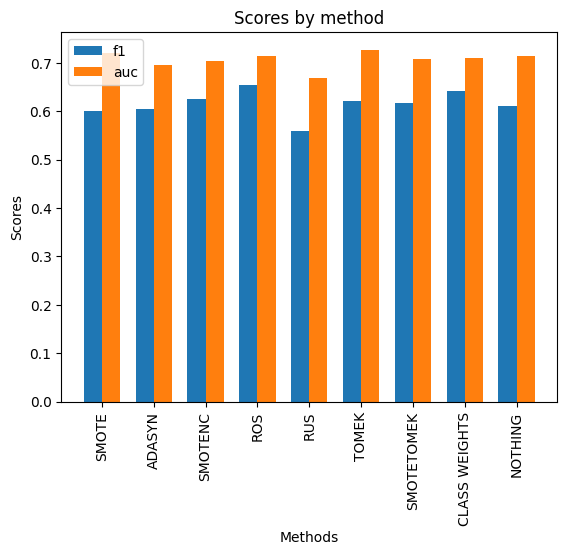

In [28]:
methods = list(results.keys())

f1_values = [results[method][0] for method in methods]
auc_values = [results[method][1] for method in methods]

bar_width = 0.35
index = np.arange(len(methods))

plt.bar(index, f1_values, bar_width, label='f1')
plt.bar(index + bar_width, auc_values, bar_width, label='auc')

plt.xlabel('Methods')
plt.xticks(index + bar_width / 2, methods)

plt.xticks(rotation=90)

plt.ylabel('Scores')
plt.title('Scores by method')

plt.legend()

plt.show()

In [29]:
model_1 = CatBoostClassifier(eval_metric='F1:use_weights=False',
                           custom_metric='F1:use_weights=False',
                           class_weights=class_weights,
                           cat_features=cat_features)

model_1.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=500)

Learning rate set to 0.03256
0:	learn: 0.4053333	test: 0.3168317	best: 0.3168317 (0)	total: 4.22ms	remaining: 4.22s
500:	learn: 0.9521277	test: 0.4285714	best: 0.4285714 (500)	total: 1.7s	remaining: 1.7s
999:	learn: 1.0000000	test: 0.4166667	best: 0.4285714 (500)	total: 3.48s	remaining: 0us

bestTest = 0.4285714286
bestIteration = 500

Shrink model to first 501 iterations.


In [30]:
pred = (model_1.predict_proba(X_test)[:, 1] >= 0.53).astype('int')
f1_score(pred, y_test, average='macro')

0.63572558323448

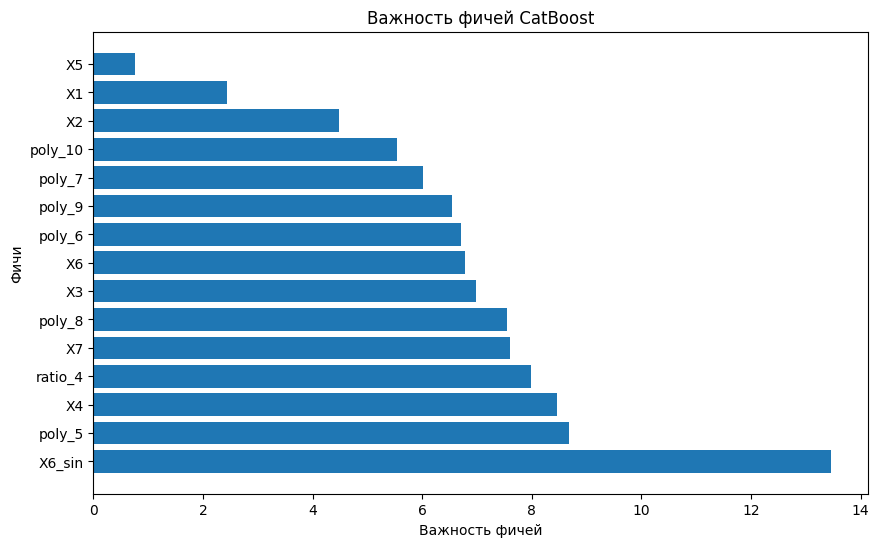

In [31]:
feature_importances = model_1.feature_importances_

feature_names = X.columns

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances, align='center')
plt.yticks(range(len(sorted_feature_importances)), sorted_feature_names)
plt.xlabel('Важность фичей')
plt.ylabel('Фичи')
plt.title('Важность фичей CatBoost')
plt.show()

In [32]:
submission = pd.read_csv('/kaggle/input/rucode-2024-1/disease_sample_submission.csv')
submission.head()

,X1,X2,X3,X4,X5,X6,X7,Y
0,1.0,2.0,27.1,102.0,2.0,130.0,12.08,0
1,2.0,2.0,26.1,84.0,2.0,77.0,3.62,1
2,1.0,2.0,20.5,100.0,2.0,100.0,13.18,0
3,1.0,2.0,33.5,97.0,2.0,105.0,13.61,0
4,1.0,2.0,24.4,106.0,2.0,104.0,8.18,0


In [33]:
test = pd.read_csv('/kaggle/input/rucode-2024-1/disease_public_test.csv')
test.head()

,X1,X2,X3,X4,X5,X6,X7
0,1.0,2.0,27.1,102.0,2.0,130.0,12.08
1,2.0,2.0,26.1,84.0,2.0,77.0,3.62
2,1.0,2.0,20.5,100.0,2.0,100.0,13.18
3,1.0,2.0,33.5,97.0,2.0,105.0,13.61
4,1.0,2.0,24.4,106.0,2.0,104.0,8.18


In [34]:
for feat in cat_features:
    test[feat] = test[feat].astype('int16')

In [35]:
test['X6_sin'] = np.sin(test['X6'])
# test['X4_cos'] = np.cos(test['X4'])
test['ratio_4'] = test['X4'] / test['X6']

In [36]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True)

poly_features = poly.fit_transform(test[num_features])
poly_feature_names_1 = [f'poly_{i}' for i in range(poly_features.shape[1])]

test_poly_1 = pd.DataFrame(poly_features, columns=poly_feature_names_1)
test = pd.concat([test, test_poly_1], axis=1)

In [37]:
test = test.drop(['poly_0', 'poly_1', 'poly_2', 'poly_3', 'poly_4'], axis=1)

In [38]:
submission['Y'] = (model_1.predict_proba(test)[:, 1] >= 0.53).astype('int')
submission.to_csv(f'final_053.csv')

In [39]:
model_1.save_model('best_model_69')

In [40]:
# bluecast -> 66.51
# голый катбуст с весами и порогом 0.58 -> 68.78
# к катбусту добавил x4/x6, sin(x6) и порог 0.53 -> 69.04 BEST